## CDS522 Text and Speech Analytics
### Project - Sentiment Analysis of IMBD dataset


| Name | Matrix No. |
| ---| --- |
| Gan Zhong Li | P-COM0156/21 |
| Tang Eva | P-COM0179/21 |

##### 1. Load necessary packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import wordnet
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import lightgbm as lgb


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\SVC-
[nltk_data]     MLDEV.SERVICE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SVC-
[nltk_data]     MLDEV.SERVICE\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\SVC-
[nltk_data]     MLDEV.SERVICE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\SVC-
[nltk_data]     MLDEV.SERVICE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### 2. Load dataset from csv

In [2]:
# import dataset
# for sentiment label, 1 indicates positive sentiment, while 0 indicates negative sentiment
test = pd.read_csv("Test.csv")
train = pd.read_csv("Train.csv")
valid = pd.read_csv("Valid.csv")

In [3]:
# joint dataset into one
imdb_data = pd.concat([test, train, valid], ignore_index=True)
imdb_data

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0
...,...,...
49995,"Man, I loved this movie! This really takes me ...",1
49996,Recovery is an incredibly moving piece of work...,1
49997,"You can take the crook out of the joint, but i...",1
49998,FUTZ is the only show preserved from the exper...,1


##### 3. Data exploration

[Text(0, 0, '25000'), Text(0, 0, '25000')]

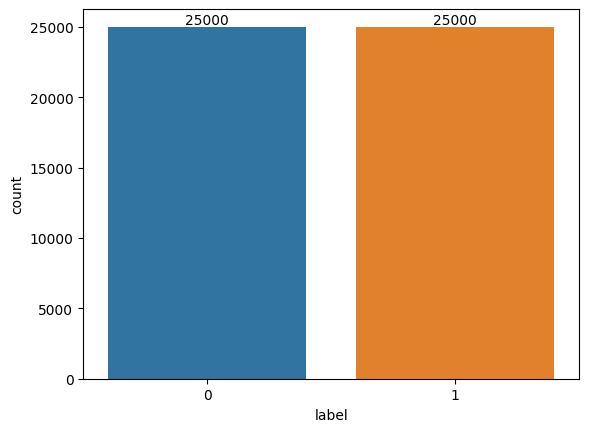

In [4]:
# get number of positive and negative sentiment
ax = sns.countplot(x=imdb_data["label"])
ax.bar_label(ax.containers[0])


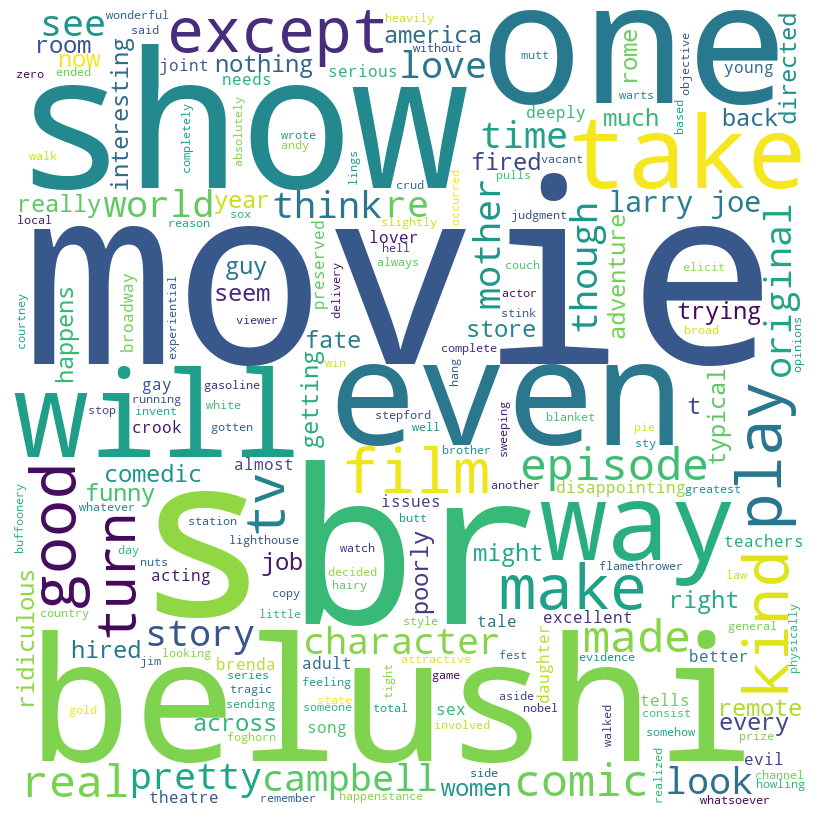

In [5]:
# Generate wordcloud
# calling the WordCloud class
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(str(imdb_data["text"].values).lower())
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

##### 4. Data pre-processing

clean html tags, to lowercase, remove special characters and punctuations, strip whitespace, remove stopwords, normalization - lemmatization

In [6]:
# clean html tags
CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

imdb_data["text"] = imdb_data["text"].apply(cleanhtml)

In [7]:
# to lowercase
imdb_data["text"] = imdb_data["text"].apply(lambda x: x.lower())
imdb_data["text"]

0        i always wrote this series off as being a comp...
1        1st watched 12/7/2002 - 3 out of 10(dir-steve ...
2        this movie was so poorly written and directed ...
3        the most interesting thing about miryang (secr...
4        when i first read about "berlin am meer" i did...
                               ...                        
49995    man, i loved this movie! this really takes me ...
49996    recovery is an incredibly moving piece of work...
49997    you can take the crook out of the joint, but i...
49998    futz is the only show preserved from the exper...
49999    "the mother" tells of a recently widowed mid-6...
Name: text, Length: 50000, dtype: object

In [8]:
# special characters and punctuation removal
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,' ',text)
    return text

imdb_data["text"] = imdb_data["text"].apply(remove_special_characters)
imdb_data["text"]

0        i always wrote this series off as being a comp...
1        1st watched 12 7 2002   3 out of 10 dir steve ...
2        this movie was so poorly written and directed ...
3        the most interesting thing about miryang  secr...
4        when i first read about  berlin am meer  i did...
                               ...                        
49995    man  i loved this movie  this really takes me ...
49996    recovery is an incredibly moving piece of work...
49997    you can take the crook out of the joint  but i...
49998    futz is the only show preserved from the exper...
49999     the mother  tells of a recently widowed mid 6...
Name: text, Length: 50000, dtype: object

In [9]:
# strip extra whitespaces
imdb_data["text"] = imdb_data["text"].apply(lambda x: re.sub(r"\s+", " ", x))
imdb_data["text"]

0        i always wrote this series off as being a comp...
1        1st watched 12 7 2002 3 out of 10 dir steve pu...
2        this movie was so poorly written and directed ...
3        the most interesting thing about miryang secre...
4        when i first read about berlin am meer i didn ...
                               ...                        
49995    man i loved this movie this really takes me ba...
49996    recovery is an incredibly moving piece of work...
49997    you can take the crook out of the joint but it...
49998    futz is the only show preserved from the exper...
49999     the mother tells of a recently widowed mid 60...
Name: text, Length: 50000, dtype: object

In [10]:
# stopwords removal

stop_words = stopwords.words("english")

def remove_stopwords(sentence): 
    tokens = word_tokenize(text=sentence)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop_words]
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

imdb_data["text"] = imdb_data["text"].apply(remove_stopwords)
imdb_data["text"]

0        always wrote series complete stink fest jim be...
1        1st watched 12 7 2002 3 10 dir steve purcell t...
2        movie poorly written directed fell asleep 30 m...
3        interesting thing miryang secret sunshine acto...
4        first read berlin meer expect much thought rig...
                               ...                        
49995    man loved movie really takes back kid days tea...
49996    recovery incredibly moving piece work handling...
49997    take crook joint seems exceedingly difficult t...
49998    futz show preserved experimental theatre movem...
49999    mother tells recently widowed mid 60 mother tw...
Name: text, Length: 50000, dtype: object

In [11]:
# lemmatization based on POS tagging

# POS tagging
imdb_data["text"] = imdb_data["text"].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
imdb_data["text"]

0        [(always, RB), (wrote, VBD), (series, NN), (co...
1        [(1st, CD), (watched, VBD), (12, CD), (7, CD),...
2        [(movie, NN), (poorly, RB), (written, VBN), (d...
3        [(interesting, JJ), (thing, NN), (miryang, NN)...
4        [(first, RB), (read, VB), (berlin, NN), (meer,...
                               ...                        
49995    [(man, NN), (loved, VBD), (movie, NN), (really...
49996    [(recovery, NN), (incredibly, RB), (moving, VB...
49997    [(take, VB), (crook, NN), (joint, NN), (seems,...
49998    [(futz, NN), (show, NN), (preserved, VBD), (ex...
49999    [(mother, NN), (tells, NNS), (recently, RB), (...
Name: text, Length: 50000, dtype: object

In [12]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return "a"
    elif treebank_tag.startswith('V'):
        return "v"
    elif treebank_tag.startswith('N'):
        return "n"
    elif treebank_tag.startswith('R'):
        return "r"
    else:
        return None

imdb_data["lemma_text"] = imdb_data["text"].transform(lambda x: ' '.join([lemmatizer.lemmatize(a[0],pos=get_wordnet_pos(a[1])) if get_wordnet_pos(a[1]) else a[0] for a in  x]))
imdb_data["lemma_text"]

0        always write series complete stink fest jim be...
1        1st watch 12 7 2002 3 10 dir steve purcell typ...
2        movie poorly write direct fell asleep 30 minut...
3        interesting thing miryang secret sunshine acto...
4        first read berlin meer expect much think right...
                               ...                        
49995    man love movie really take back kid day teache...
49996    recovery incredibly move piece work handle dev...
49997    take crook joint seem exceedingly difficult ta...
49998    futz show preserve experimental theatre moveme...
49999    mother tell recently widow mid 60 mother two a...
Name: lemma_text, Length: 50000, dtype: object

In [13]:
imdb_data.to_csv("lemma.csv", index=False)
# imdb_data = pd.read_csv("lemma.csv")

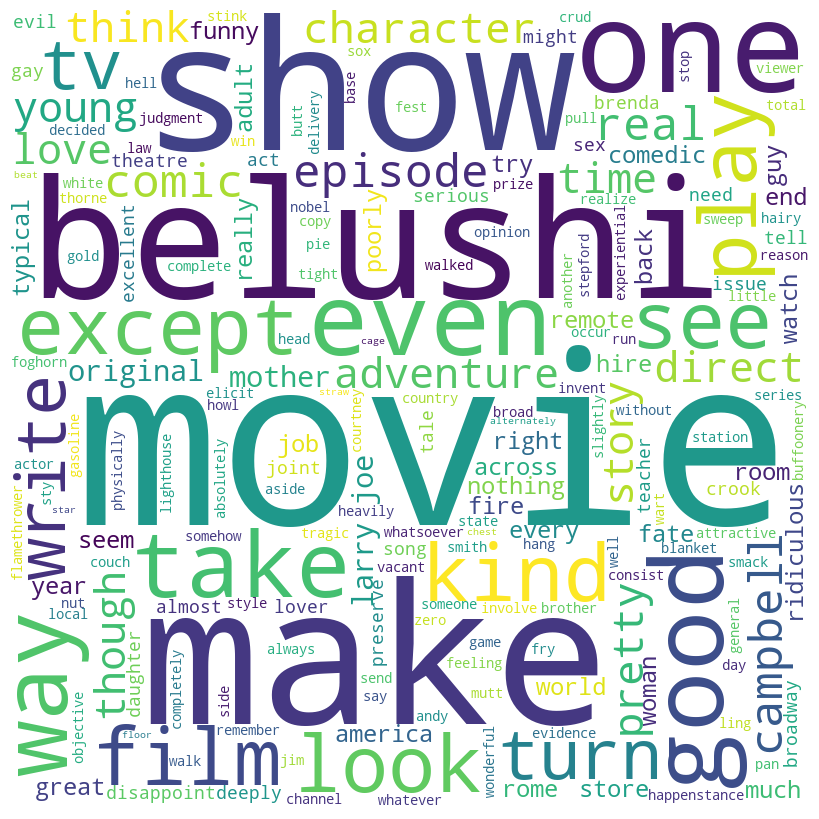

In [14]:
# Generate wordcloud
# calling the WordCloud class
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(str(imdb_data["lemma_text"].values).lower())
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

<AxesSubplot: xlabel='count', ylabel='word'>

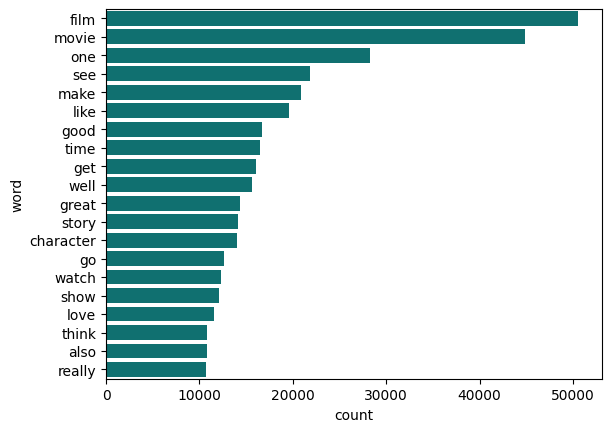

In [73]:
# Top 20 words from positive reviews
from collections import Counter
positive_count = Counter(" ".join(imdb_data[imdb_data["label"]==1]["lemma_text"]).split()).most_common(20)
positive_count_df = pd.DataFrame(positive_count, columns=["word", "count"])
sns.barplot(x="count", y="word" , data=positive_count_df, color="teal")

<AxesSubplot: xlabel='count', ylabel='word'>

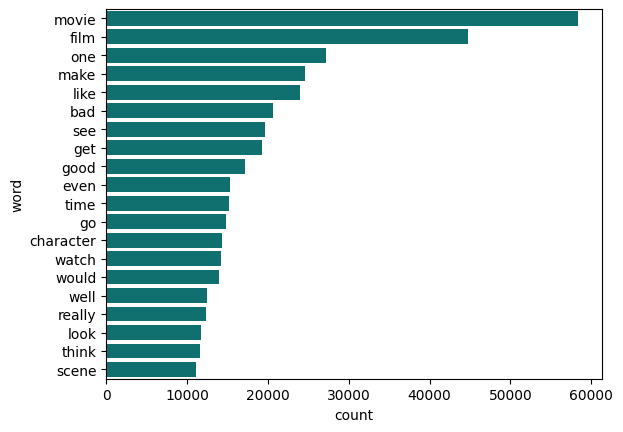

In [75]:
# Top 20 words from negative reviews
negative_count = Counter(" ".join(imdb_data[imdb_data["label"]==0]["lemma_text"]).split()).most_common(20)
negative_count_df = pd.DataFrame(negative_count, columns=["word", "count"])
sns.barplot(x="count", y="word" , data=negative_count_df, color="teal")


#### For unigram

##### 5. Feature extraction

Bag of words vectorizer

In [15]:
cv = CountVectorizer()

X_bow = cv.fit_transform(imdb_data["lemma_text"])

X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow, imdb_data["label"], train_size=0.8, random_state=0, stratify=imdb_data["label"])

TF-IDF vectorizer

In [16]:
tv = TfidfVectorizer()

X_tfidf = tv.fit_transform(imdb_data["lemma_text"])

X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, imdb_data["label"], train_size=0.8, random_state=0, stratify=imdb_data["label"])

##### 6. Modelling

Multinomial Naive bayes

In [17]:
# training the model
mnbbow = MultinomialNB()
mnbtfidf = MultinomialNB()
mnb_params = {"alpha": [0, 1], "force_alpha": [True, False]}

mnb_bow = GridSearchCV(mnbbow, mnb_params, n_jobs=-1)
mnb_tfidf = GridSearchCV(mnbtfidf, mnb_params, n_jobs=-1)

# fitting the mnb for bag of words
mnb_bow.fit(X_bow_train, y_bow_train)
print(mnb_bow.best_estimator_)

# fitting the mnb for tfidf features
mnb_tfidf.fit(X_bow_train, y_tfidf_train)
print(mnb_tfidf.best_estimator_)

MultinomialNB(alpha=1, force_alpha=True)
MultinomialNB(alpha=1, force_alpha=True)


In [18]:
# Predicting the model for bag of words
mnb_bow_predict = mnb_bow.predict(X_bow_test)
print(mnb_bow_predict)

# Predicting the model for tfidf features
mnb_tfidf_predict = mnb_tfidf.predict(X_tfidf_test)
print(mnb_tfidf_predict)

[0 0 1 ... 0 1 0]
[0 0 1 ... 0 1 0]


In [19]:
# Accuracy score for bag of words
mnb_bow_score = accuracy_score(y_bow_test, mnb_bow_predict)
print("mnb_bow accuracy score: ", mnb_bow_score)

# Accuracy score for tfidf features
mnb_tfidf_score = accuracy_score(y_tfidf_test, mnb_tfidf_predict)
print("mnb_tfidf accuracy score: ", mnb_tfidf_score)

mnb_bow accuracy score:  0.857
mnb_tfidf accuracy score:  0.8507


Logistic regression

In [20]:
# training the model
lrbow = LogisticRegression()
lrtfidf = LogisticRegression()
lr_params = {"C": [0.1, 1], "random_state": [0]}

lr_bow = GridSearchCV(lrbow, lr_params, n_jobs=-1)
lr_tfidf = GridSearchCV(lrtfidf, lr_params, n_jobs=-1)

# Fitting the model for Bag of words
lr_bow.fit(X_bow_train, y_bow_train)
print(lr_bow.best_estimator_)

# Fitting the model for tfidf features
lr_tfidf.fit(X_tfidf_train, y_tfidf_train)
print(lr_tfidf.best_estimator_)

c:\Users\SVC-MLDEV.SERVICE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, random_state=0)
LogisticRegression(C=1, random_state=0)


In [21]:
# Predicting the model for bag of words features
lr_bow_predict = lr_bow.predict(X_bow_test)
print(lr_bow_predict)

# Predicting the model for tfidf features
lr_tfidf_predict = lr_tfidf.predict(X_tfidf_test)
print(lr_tfidf_predict)

[0 1 1 ... 0 0 0]
[0 1 1 ... 0 0 0]


In [22]:
# Accuracy score for bag of words
lr_bow_score = accuracy_score(y_bow_test, lr_bow_predict)
print("lr_bow accuracy score: ", lr_bow_score)

# Accuracy score for tfidf features
lr_tfidf_score = accuracy_score(y_tfidf_test, lr_tfidf_predict)
print("lr_tfidf accuracy score: ", lr_tfidf_score)

lr_bow accuracy score:  0.8951
lr_tfidf accuracy score:  0.8943


Decision Tree

In [23]:
# training the model
dtbow = DecisionTreeClassifier()
dttfidf = DecisionTreeClassifier()
dt_params = {"max_depth": [10, 20], "min_samples_leaf": [10, 20, 30], "min_samples_split": [10, 20, 30], "random_state":[0]}


dt_bow = GridSearchCV(dtbow, dt_params, n_jobs=-1)
dt_tfidf = GridSearchCV(dttfidf, dt_params, n_jobs=-1)

# training the dt for bag of words features
dt_bow.fit(X_bow_train, y_bow_train)
print(dt_bow.best_estimator_)

# training the dt for tfidf features
dt_tfidf.fit(X_tfidf_train, y_tfidf_train)
print(dt_tfidf.best_estimator_)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=30, min_samples_split=10,
                       random_state=0)
DecisionTreeClassifier(max_depth=20, min_samples_leaf=30, min_samples_split=10,
                       random_state=0)


In [24]:
# Predicting the model for bag of words features
dt_bow_predict = dt_bow.predict(X_bow_test)
print(dt_bow_predict)

# Predicting the model for tfidf features
dt_tfidf_predict = dt_tfidf.predict(X_tfidf_test)
print(dt_tfidf_predict)

[0 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]


In [25]:
# Accuracy score for bag of words
dt_bow_score = accuracy_score(y_bow_test, dt_bow_predict)
print("dt_bow accuracy score: ", dt_bow_score)

# Accuracy score for tfidf features
dt_tfidf_score = accuracy_score(y_tfidf_test, dt_tfidf_predict)
print("dt_tfidf accuracy score: ", dt_tfidf_score)

dt_bow accuracy score:  0.7528
dt_tfidf accuracy score:  0.7419


XGBoost

In [26]:
# training the model
xgbbow = XGBClassifier()
xgbtfidf = XGBClassifier()
xgb_params = {"n_estimators": [10, 20], "max_depth": [2, 4, 8], "learning_rate": [1], "objective": ["binary:logistic"], "random_state": [0]}

xgb_bow = GridSearchCV(xgbbow, xgb_params, n_jobs=-1)
xgb_tfidf = GridSearchCV(xgbtfidf, xgb_params, n_jobs=-1)

# training the xgb for bag of words features
xgb_bow.fit(X_bow_train, y_bow_train)

# training the xgb for tfidf features
xgb_tfidf.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [1], 'max_depth': [2, 4, 8],
                         'n_estimators': [10, 20],
                         'objective': ['binary:logistic'],
                         'random_state': [0]})

In [27]:
print(xgb_bow.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


In [28]:
print(xgb_tfidf.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


In [29]:
# Predicting the model for bag of words features
xgb_bow_predict = xgb_bow.predict(X_bow_test)
print(xgb_bow_predict)

# Predicting the model for tfidf features
xgb_tfidf_predict = xgb_tfidf.predict(X_tfidf_test)
print(xgb_tfidf_predict)

[0 0 1 ... 0 0 0]
[0 1 1 ... 0 0 0]


In [30]:
# Accuracy score for bag of words
xgb_bow_score = accuracy_score(y_bow_test, xgb_bow_predict)
print("xgb_bow accuracy score: ", xgb_bow_score)

# Accuracy score for tfidf features
xgb_tfidf_score = accuracy_score(y_tfidf_test, xgb_tfidf_predict)
print("xgb_tfidf accuracy score: ", xgb_tfidf_score)

xgb_bow accuracy score:  0.8281
xgb_tfidf accuracy score:  0.8224


LightGBM

In [31]:
# training the model
lgbcbow = lgb.LGBMClassifier()
lgbctfidf = lgb.LGBMClassifier()
lgbc_params = {"n_estimators": [10, 20], "max_depth": [2, 4, 8], "learning_rate": [1], "objective": ["binary"], "random_state": [0]}

lgbc_bow = GridSearchCV(lgbcbow, lgbc_params, n_jobs=-1)
lgbc_tfidf = GridSearchCV(lgbctfidf, lgbc_params, n_jobs=-1)

# training the lgbc for bag of words features
lgbc_bow.fit(X_bow_train.astype("float32"), y_bow_train.astype("float32"))

# training the lgbc for tfidf features
lgbc_tfidf.fit(X_tfidf_train.astype("float32"), y_tfidf_train.astype("float32"))

GridSearchCV(estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1], 'max_depth': [2, 4, 8],
                         'n_estimators': [10, 20], 'objective': ['binary'],
                         'random_state': [0]})

In [32]:
print(lgbc_bow.best_estimator_)

LGBMClassifier(learning_rate=1, max_depth=8, n_estimators=20,
               objective='binary', random_state=0)


In [33]:
print(lgbc_tfidf.best_estimator_)

LGBMClassifier(learning_rate=1, max_depth=8, n_estimators=20,
               objective='binary', random_state=0)


In [34]:
# Predicting the model for bag of words features
lgbc_bow_predict = lgbc_bow.predict(X_bow_test.astype("float32"))
print(lgbc_bow_predict)

# Predicting the model for tfidf features
lgbc_tfidf_predict = lgbc_tfidf.predict(X_tfidf_test.astype("float32"))
print(lgbc_tfidf_predict)

[0. 1. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]


In [35]:
# Accuracy score for bag of words
lgbc_bow_score = accuracy_score(y_bow_test, lgbc_bow_predict)
print("lgbc_bow accuracy score: ", lgbc_bow_score)

# Accuracy score for tfidf features
lgbc_tfidf_score = accuracy_score(y_tfidf_test, lgbc_tfidf_predict)
print("lgbc_tfidf accuracy score: ", lgbc_tfidf_score)

lgbc_bow accuracy score:  0.8295
lgbc_tfidf accuracy score:  0.8269


#### For bigram

##### 5. Feature extraction

Bag of words vectorizer

In [36]:
cv = CountVectorizer(ngram_range=(2,2))

X_bi_bow = cv.fit_transform(imdb_data["lemma_text"])

X_bi_bow_train, X_bi_bow_test, y_bi_bow_train, y_bi_bow_test = train_test_split(X_bi_bow, imdb_data["label"], train_size=0.8, random_state=0, stratify=imdb_data["label"])

TF-IDF vectorizer

In [37]:
tv = TfidfVectorizer(ngram_range=(2,2))

X_bi_tfidf = tv.fit_transform(imdb_data["lemma_text"])

X_bi_tfidf_train, X_bi_tfidf_test, y_bi_tfidf_train, y_bi_tfidf_test = train_test_split(X_bi_tfidf, imdb_data["label"], train_size=0.8, random_state=0, stratify=imdb_data["label"])

##### 6. Modelling

Multinomial Naive bayes

In [38]:
# training the model
mnbbow = MultinomialNB()
mnbtfidf = MultinomialNB()
mnb_params = {"alpha": [0, 1], "force_alpha": [True, False]}

mnb_bi_bow = GridSearchCV(mnbbow, mnb_params, n_jobs=-1)
mnb_bi_tfidf = GridSearchCV(mnbtfidf, mnb_params, n_jobs=-1)

# fitting the mnb for bag of words
mnb_bi_bow.fit(X_bi_bow_train, y_bi_bow_train)
print(mnb_bi_bow.best_estimator_)

# fitting the mnb for tfidf features
mnb_bi_tfidf.fit(X_bi_bow_train, y_bi_tfidf_train)
print(mnb_bi_tfidf.best_estimator_)

MultinomialNB(alpha=1, force_alpha=True)
MultinomialNB(alpha=1, force_alpha=True)


In [39]:
# Predicting the model for bag of words
mnb_bi_bow_predict = mnb_bi_bow.predict(X_bi_bow_test)
print(mnb_bi_bow_predict)

# Predicting the model for tfidf features
mnb_bi_tfidf_predict = mnb_bi_tfidf.predict(X_bi_tfidf_test)
print(mnb_bi_tfidf_predict)

[0 0 1 ... 0 1 0]
[0 0 1 ... 0 1 0]


In [40]:
# Accuracy score for bag of words
mnb_bi_bow_score = accuracy_score(y_bi_bow_test, mnb_bi_bow_predict)
print("mnb_bi_bow accuracy score: ", mnb_bi_bow_score)

# Accuracy score for tfidf features
mnb_bi_tfidf_score = accuracy_score(y_bi_tfidf_test, mnb_bi_tfidf_predict)
print("mnb_bi_tfidf accuracy score: ", mnb_bi_tfidf_score)

mnb_bi_bow accuracy score:  0.8809
mnb_bi_tfidf accuracy score:  0.8799


Logistic regression

In [41]:
# training the model
lrbow = LogisticRegression()
lrtfidf = LogisticRegression()
lr_params = {"penalty": [None, 'l2'], "C": [0.1, 1], "random_state": [0]}

lr_bi_bow = GridSearchCV(lrbow, lr_params, n_jobs=-1)
lr_bi_tfidf = GridSearchCV(lrtfidf, lr_params, n_jobs=-1)

# Fitting the model for Bag of words
lr_bi_bow.fit(X_bi_bow_train, y_bi_bow_train)
print(lr_bi_bow.best_estimator_)

# Fitting the model for tfidf features
lr_bi_tfidf.fit(X_bi_tfidf_train, y_bi_tfidf_train)
print(lr_bi_tfidf.best_estimator_)

LogisticRegression(C=1, random_state=0)


c:\Users\SVC-MLDEV.SERVICE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.1, penalty=None, random_state=0)


In [42]:
# Predicting the model for bag of words features
lr_bi_bow_predict = lr_bi_bow.predict(X_bi_bow_test)
print(lr_bi_bow_predict)

# Predicting the model for tfidf features
lr_bi_tfidf_predict = lr_bi_tfidf.predict(X_bi_tfidf_test)
print(lr_bi_tfidf_predict)

[1 0 1 ... 0 1 0]
[0 0 1 ... 0 0 0]


In [43]:
# Accuracy score for bag of words
lr_bi_bow_score = accuracy_score(y_bi_bow_test, lr_bi_bow_predict)
print("lr_bi_bow accuracy score: ", lr_bi_bow_score)

# Accuracy score for tfidf features
lr_bi_tfidf_score = accuracy_score(y_bi_tfidf_test, lr_bi_tfidf_predict)
print("lr_bi_tfidf accuracy score: ", lr_bi_tfidf_score)

lr_bi_bow accuracy score:  0.8643
lr_bi_tfidf accuracy score:  0.8679


Decision Tree

In [44]:
# training the model
dtbow = DecisionTreeClassifier()
dttfidf = DecisionTreeClassifier()
dt_params = {"max_depth": [10, 20], "min_samples_leaf": [10, 20, 30], "min_samples_split": [10, 20, 30], "random_state":[0]}


dt_bi_bow = GridSearchCV(dtbow, dt_params, n_jobs=-1)
dt_bi_tfidf = GridSearchCV(dttfidf, dt_params, n_jobs=-1)

# training the dt for bag of words features
dt_bi_bow.fit(X_bi_bow_train, y_bi_bow_train)
print(dt_bi_bow.best_estimator_)

# training the dt for tfidf features
dt_bi_tfidf.fit(X_bi_tfidf_train, y_bi_tfidf_train)
print(dt_bi_tfidf.best_estimator_)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=30, min_samples_split=10,
                       random_state=0)
DecisionTreeClassifier(max_depth=20, min_samples_leaf=20, min_samples_split=10,
                       random_state=0)


In [45]:
# Predicting the model for bag of words features
dt_bi_bow_predict = dt_bi_bow.predict(X_bi_bow_test)
print(dt_bi_bow_predict)

# Predicting the model for tfidf features
dt_bi_tfidf_predict = dt_bi_tfidf.predict(X_bi_tfidf_test)
print(dt_bi_tfidf_predict)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [46]:
# Accuracy score for bag of words
dt_bi_bow_score = accuracy_score(y_bi_bow_test, dt_bi_bow_predict)
print("dt_bi_bow accuracy score: ", dt_bi_bow_score)

# Accuracy score for tfidf features
dt_bi_tfidf_score = accuracy_score(y_bi_tfidf_test, dt_bi_tfidf_predict)
print("dt_bi_tfidf accuracy score: ", dt_bi_tfidf_score)

dt_bi_bow accuracy score:  0.6303
dt_bi_tfidf accuracy score:  0.6262


XGBoost

In [47]:
# training the model
xgbbow = XGBClassifier()
xgbtfidf = XGBClassifier()
xgb_params = {"n_estimators": [10, 20], "max_depth": [2, 4, 8], "learning_rate": [1], "objective": ["binary:logistic"], "random_state": [0]}

xgb_bi_bow = GridSearchCV(xgbbow, xgb_params, n_jobs=-1)
xgb_bi_tfidf = GridSearchCV(xgbtfidf, xgb_params, n_jobs=-1)

# training the xgb for bag of words features
xgb_bi_bow.fit(X_bi_bow_train, y_bi_bow_train)

# training the xgb for tfidf features
xgb_bi_tfidf.fit(X_bi_tfidf_train, y_bi_tfidf_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [1], 'max_depth': [2, 4, 8],
                         'n_estimators': [10, 20],
                         'objective': ['binary:logistic'],
                         'random_state': [0]})

In [48]:
print(xgb_bi_bow.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


In [49]:
print(xgb_bi_tfidf.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


In [50]:
# Predicting the model for bag of words features
xgb_bi_bow_predict = xgb_bi_bow.predict(X_bi_bow_test)
print(xgb_bi_bow_predict)

# Predicting the model for tfidf features
xgb_bi_tfidf_predict = xgb_bi_tfidf.predict(X_bi_tfidf_test)
print(xgb_bi_tfidf_predict)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [51]:
# Accuracy score for bag of words
xgb_bi_bow_score = accuracy_score(y_bi_bow_test, xgb_bi_bow_predict)
print("xgb_bi_bow accuracy score: ", xgb_bi_bow_score)

# Accuracy score for tfidf features
xgb_bi_tfidf_score = accuracy_score(y_bi_tfidf_test, xgb_bi_tfidf_predict)
print("xgb_bi_tfidf accuracy score: ", xgb_bi_tfidf_score)

xgb_bi_bow accuracy score:  0.7254
xgb_bi_tfidf accuracy score:  0.7221


LightBGM

In [52]:
# training the model
lgbcbow = lgb.LGBMClassifier()
lgbctfidf = lgb.LGBMClassifier()
lgbc_params = {"n_estimators": [10, 20], "max_depth": [2, 4, 8], "learning_rate": [1], "objective": ["binary"], "random_state": [0]}

lgbc_bi_bow = GridSearchCV(lgbcbow, lgbc_params, n_jobs=-1)
lgbc_bi_tfidf = GridSearchCV(lgbctfidf, lgbc_params, n_jobs=-1)

# training the lgbc for bag of words features
lgbc_bi_bow.fit(X_bi_bow_train.astype("float32"), y_bi_bow_train.astype("float32"))

# training the lgbc for tfidf features
lgbc_bi_tfidf.fit(X_bi_tfidf_train.astype("float32"), y_bi_tfidf_train.astype("float32"))

c:\Users\SVC-MLDEV.SERVICE\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1], 'max_depth': [2, 4, 8],
                         'n_estimators': [10, 20], 'objective': ['binary'],
                         'random_state': [0]})

In [53]:
print(lgbc_bi_bow.best_estimator_)

LGBMClassifier(learning_rate=1, max_depth=8, n_estimators=20,
               objective='binary', random_state=0)


In [55]:
print(lgbc_bi_tfidf.best_estimator_)

LGBMClassifier(learning_rate=1, max_depth=8, n_estimators=20,
               objective='binary', random_state=0)


In [56]:
# Predicting the model for bag of words features
lgbc_bi_bow_predict = lgbc_bi_bow.predict(X_bi_bow_test.astype("float32"))
print(lgbc_bi_bow_predict)

# Predicting the model for tfidf features
lgbc_bi_tfidf_predict = lgbc_bi_tfidf.predict(X_bi_tfidf_test.astype("float32"))
print(lgbc_bi_tfidf_predict)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


In [57]:
# Accuracy score for bag of words
lgbc_bi_bow_score = accuracy_score(y_bi_bow_test, lgbc_bi_bow_predict)
print("lgbc_bi_bow accuracy score: ", lgbc_bi_bow_score)

# Accuracy score for tfidf features
lgbc_bi_tfidf_score = accuracy_score(y_bi_tfidf_test, lgbc_bi_tfidf_predict)
print("lgbc_bi_tfidf accuracy score: ", lgbc_bi_tfidf_score)

lgbc_bi_bow accuracy score:  0.7307
lgbc_bi_tfidf accuracy score:  0.7256


#### Accuracy scores

In [70]:
accuracy = {
    1: {
        "ngram": "unigram", 
        "algo": "mnb", 
        "vectorizer": "bow", 
        "accuracy": mnb_bow_score
    }, 
    2: {
        "ngram": "unigram", 
        "algo": "mnb", 
        "vectorizer": "tfidf", 
        "accuracy": mnb_tfidf_score
    }, 
    3: {
        "ngram": "unigram", 
        "algo": "lr", 
        "vectorizer": "bow", 
        "accuracy": lr_bow_score
    }, 
    4: {
        "ngram": "unigram", 
        "algo": "lr", 
        "vectorizer": "tfidf", 
        "accuracy": lr_tfidf_score
    }, 
    5: {
        "ngram": "unigram", 
        "algo": "dt", 
        "vectorizer": "bow", 
        "accuracy": dt_bow_score
    }, 
    6: {
        "ngram": "unigram", 
        "algo": "dt", 
        "vectorizer": "tfidf", 
        "accuracy": dt_tfidf_score
    }, 
    7: {
        "ngram": "unigram", 
        "algo": "xgb", 
        "vectorizer": "bow", 
        "accuracy": xgb_bow_score
    }, 
    8: {
        "ngram": "unigram", 
        "algo": "xgb", 
        "vectorizer": "tfidf", 
        "accuracy": xgb_tfidf_score
    }, 
    9: {
        "ngram": "unigram", 
        "algo": "lgbm", 
        "vectorizer": "bow", 
        "accuracy": lgbc_bow_score
    }, 
    10: {
        "ngram": "unigram", 
        "algo": "lgbm", 
        "vectorizer": "tfidf", 
        "accuracy": lgbc_tfidf_score
    }, 
    11: {
        "ngram": "bigram", 
        "algo": "mnb", 
        "vectorizer": "bow", 
        "accuracy": mnb_bi_bow_score
    }, 
    12: {
        "ngram": "bigram", 
        "algo": "mnb", 
        "vectorizer": "tfidf", 
        "accuracy": mnb_bi_tfidf_score
    }, 
    13: {
        "ngram": "bigram", 
        "algo": "lr", 
        "vectorizer": "bow", 
        "accuracy": lr_bi_bow_score
    }, 
    14: {
        "ngram": "bigram", 
        "algo": "lr", 
        "vectorizer": "tfidf", 
        "accuracy": lr_bi_tfidf_score
    }, 
    15: {
        "ngram": "bigram", 
        "algo": "dt", 
        "vectorizer": "bow", 
        "accuracy": dt_bi_bow_score
    }, 
    16: {
        "ngram": "bigram", 
        "algo": "dt", 
        "vectorizer": "tfidf", 
        "accuracy": dt_bi_tfidf_score
    }, 
    17: {
        "ngram": "bigram", 
        "algo": "xgb", 
        "vectorizer": "bow", 
        "accuracy": xgb_bi_bow_score
    }, 
    18: {
        "ngram": "bigram", 
        "algo": "xgb", 
        "vectorizer": "tfidf", 
        "accuracy": xgb_bi_tfidf_score
    }, 
    19: {
        "ngram": "bigram", 
        "algo": "lgbm", 
        "vectorizer": "bow", 
        "accuracy": lgbc_bi_bow_score
    }, 
    20: {
        "ngram": "bigram", 
        "algo": "lgbm", 
        "vectorizer": "tfidf", 
        "accuracy": lgbc_bi_tfidf_score
    }
}

In [71]:
import json
accuracy_df = pd.read_json(json.dumps(accuracy), orient="index")
accuracy_df.reset_index(drop=True, inplace=True)
accuracy_df.to_csv("accuracy.csv", index=False)

In [72]:
accuracy_df

,ngram,algo,vectorizer,accuracy
0,unigram,mnb,bow,0.8570
1,unigram,mnb,tfidf,0.8507
2,unigram,lr,bow,0.8951
3,unigram,lr,tfidf,0.8943
4,unigram,dt,bow,0.7528
5,unigram,dt,tfidf,0.7419
6,unigram,xgb,bow,0.8281
7,unigram,xgb,tfidf,0.8224
8,unigram,lgbm,bow,0.8295
9,unigram,lgbm,tfidf,0.8269
